In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation
from skimage.registration import phase_cross_correlation
from scipy import io
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
import copy
import os
base_path = os.environ['HOME']

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.set_soft_device_placement(False)


cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [3]:
tf.config.list_logical_devices()

2021-10-17 22:42:13.814949: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-17 22:42:15.897948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38428 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
tf.config.get_soft_device_placement(), gpus[0]

(False, PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'))

In [6]:
gpus[0].name

'/physical_device:GPU:0'

In [7]:
!pwd

/gpfs/fs1/home/skandel/code/mbptycho/mbptycho/tests/point_inclusions_sparse_scan/apodized_probe_weak_peaks


In [8]:
strain_type = 'point_inclusion'
probes_3d_h5_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/probes.h5'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/apodized_probe_weak_peaks'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'


In [9]:
!ls $sim_data_path

/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/apodized_probe_weak_peaks/sim_point_inclusion.pkl


In [10]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.params.sample_pix_size

File exists. Reloading...


0.005844363636363636

## Directly reconstructing the displacements

In [17]:
recons = DisplacementFullModelReconstruction(simulation=sm, 
                                             shared_magnitudes=True, 
                                             unwrap_phase_proj=True, 
                                             batch_size=50)

Setting background_level to 1e-08...


In [18]:
disp_lr = 1e-2
magnitude_lr = 1e-1
if not 'ux_uy_2d_v' in recons.optimizers:
    recons.setDisplacementAdamOptimizer(disp_lr)
else:
    recons.optimizers['ux_uy_2d_v']['learning_rate'].assign(disp_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

recons.optimizers

{'ux_uy_2d_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.01>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x1528acef5640>,
  'var': <tf.Variable 'ux_uy:0' shape=(16530,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>},
 'magnitudes_log_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x1528acef56a0>,
  'var': <tf.Variable 'magnitudes_log_v:0' shape=(8268,) dtype=float32, numpy=
  array([-16.118095, -16.118095, -16.118095, ...,   0.      ,   0.      ,
           0.      ], dtype=float32)>}}

In [19]:
recons.minimize(1000, debug_output_epoch_frequency=10)

Initializing the datalog...
<tf.Variable 'Variable:0' shape=(50,) dtype=int32>
Instructions for updating:
Use fn_output_signature instead
<tf.Variable 'Variable:0' shape=(50,) dtype=int32>


2021-10-17 22:50:14.349032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-17 22:50:18.338375: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


        epoch  train_loss     err_ux     err_uy  err_ux_film  err_uy_film   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
60         10    2.66e+04      0.843      0.896        0.831        0.849      0.838      0.701      0.948      0.905          0.844          0.677          0.956          0.873
120         20   2.32e+04      0.686      0.722      0.654      0.717       0.86      0.619      0.954      0.874      0.784      0.595      0.942      0.865
180         30   1.74e+04      0.663      0.582       0.64      0.517      0.903      0.392      0.954      0.865      0.854      0.355      0.955      0.835
240         40   1.64e+04      0.651      0.528       0.63       0.45      0.923      0.363      0.924      0.887       0.88      0.321      0.925      0.846
300         50   3.16e+04      0.638      0.515      0.619      0.431      0.939      0.372      0.887      0.908      0.897       0.33      0.887      0.867
360         

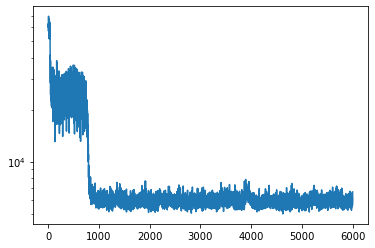

In [20]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [22]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = phase_cross_correlation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

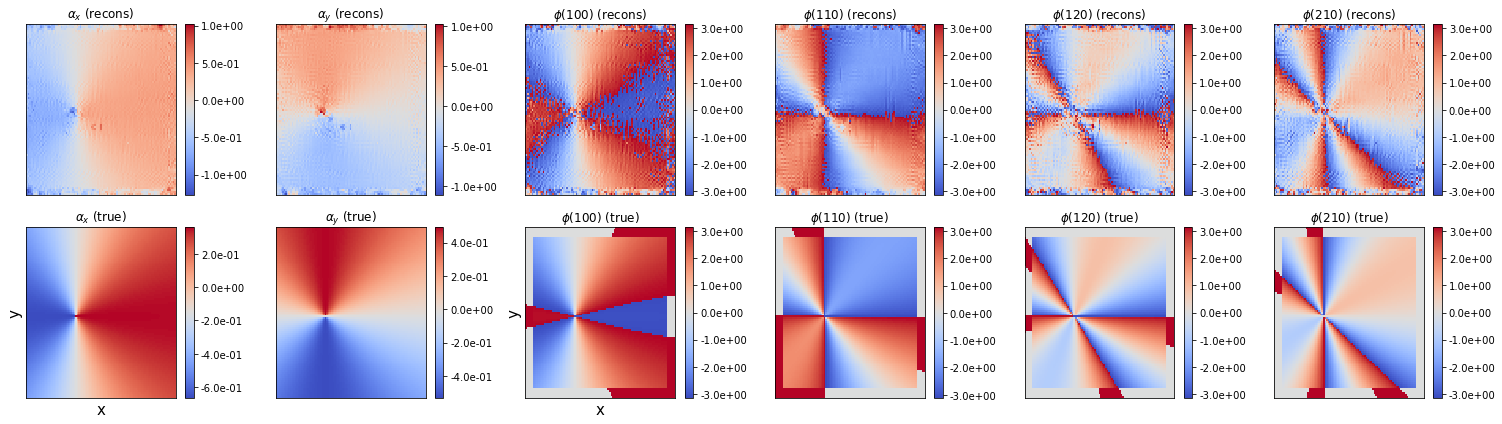

In [23]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

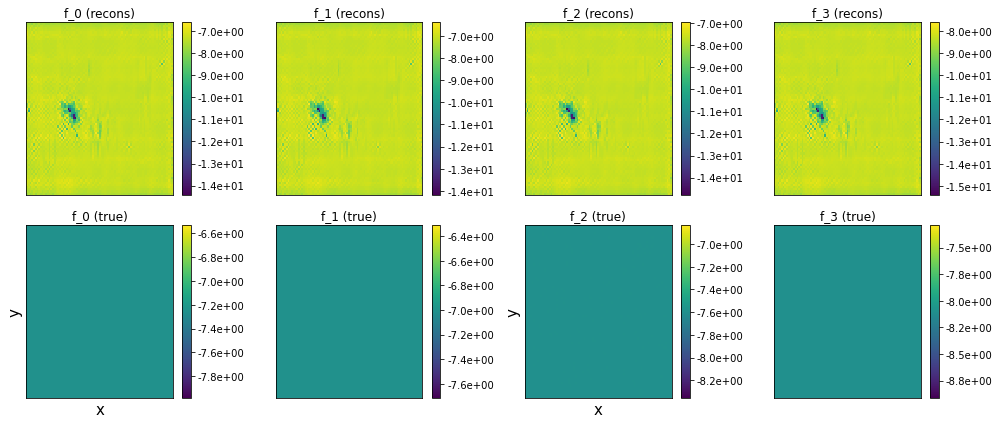

In [24]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = np.abs(recons.rho_2d[i][5:-5,5:-5])
    true_amplitudes = np.abs(recons._rho_true[i][5:-5,5:-5])
    
    cp0 = axs[0, i].pcolormesh(np.log(recons_amplitudes))
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(np.log(true_amplitudes))
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [58]:
recons.saveOutputsAndLog(data_path, prefix='direct_projected_')

In [33]:
!ls $data_path

direct_projected_df_displacement_to_data_shared_mags.gz
direct_projected_rho_displacement_to_data_shared_mags.npz
direct_projected_ux_displacement_to_data_shared_mags.npz
direct_projected_uy_displacement_to_data_shared_mags.npz
sample_point_inclusion.pkl
sim_point_inclusion.pkl


In [34]:
import pandas as pd

In [35]:
dload = pd.read_pickle(f'{data_path}/direct_projected_df_displacement_to_data_shared_mags.gz')

In [36]:
dload

,epoch,train_loss,err_ux,err_uy,err_ux_film,err_uy_film,err_rho0,err_rho1,err_rho2,err_rho3,err_rho_film0,err_rho_film1,err_rho_film2,err_rho_film3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,206944.593750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,226572.562500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,206152.265625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,238338.265625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,111.0,8091.377930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
663,111.0,6840.916992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
664,111.0,8628.835938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665,111.0,7674.362305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
ux = recons_items[r'$\alpha_x$']
uy = recons_items[r'$\alpha_y$']

In [38]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

In [39]:
sm.sample.params.lattice

array([0.0003905, 0.0003905, 0.0003905])

In [40]:

import matplotlib.colors as colors

<ipython-input-41-13f38f747939>:11: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,


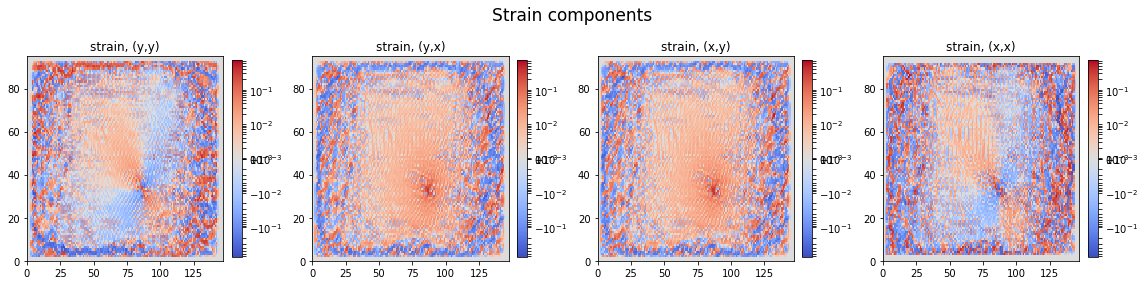

In [41]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl#[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [42]:
s.max(), s.min()

(0.758537769317627, -0.902333676815033)

In [43]:
ux = true_items[r'$\alpha_x$']
uy = true_items[r'$\alpha_y$']

In [44]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

<ipython-input-45-372bd4323cac>:11: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,


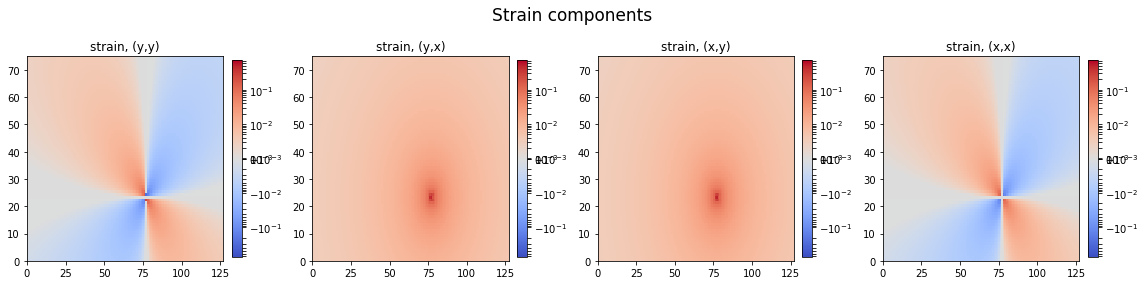

In [45]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-0.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [102]:
sl.max()

0.14155861493467398

In [106]:
s.max(), s.min()

(0.512089098698885, -0.2560819462227913)